## Imports

In [6]:
%matplotlib inline

import venn
import numpy as np
import pandas as pd
import plotly
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

from plotly.subplots import make_subplots
from tqdm import tqdm
import os
import networkx as nx
import glob as glob

pio.templates.default = 'plotly_white'
pd.options.mode.chained_assignment = None

## Load in adjacency matrices and turn them into networkx graphs

In [2]:
def load_edge_mat(fn):
    mat = pd.read_csv(fn, sep=",", index_col=0)
    return mat

network_fn = glob.glob("*.csv")

mats = dict()
g_list = dict()

for f in network_fn:
    name = f.split(".")[0]
    mat = load_edge_mat(f)
    mats[name] = mat
    
    g = nx.from_pandas_adjacency(mat, nx.DiGraph)
    g_list[name] = g

In [62]:
mats.keys()

dict_keys(['sCerevisiae', 'gMetallireducens', 'kPneumoniae', 'bSubtilis', 'eColi'])

In [4]:
mat = mats['sCerevisiae']
mat.head()

,13BGH,13GS,GLUK,HEX1,SBTR,GALUi,NDP7,NDPK2,RNDR4,UDPG4E,...,CERS124er,CERS126er,CERS224er,CERS226er,G6PDH2er,SBPP1er,SBPP2er,BACCL,PPBNGS,CPPPGO
13BGH,0,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13GS,1,0,0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
GLUK,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HEX1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SBTR,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
mats['eColi']

,2AGPEAT120,APH120,FA120ACPHi,FACOAE120,LPLIPAL2A120,LPLIPAL2E120,LPLIPAL2G120,2AGPGAT120,AACPS7,ACPPAT120,...,POAACR,3KGK,ASCBPL,LYXI,GOFUCR,2DGULRx,2DGULRy,3AMACHYD,DOGULNR,MSAR
2AGPEAT120,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
APH120,1,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
FA120ACPHi,1,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
FACOAE120,1,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
LPLIPAL2A120,1,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2DGULRx,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2DGULRy,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3AMACHYD,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
DOGULNR,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


## Compute some summary statistics on each graph, then compute overlap

### In and out degrees

In [3]:
# compute in and out degrees for each organism and rank
ins = dict()
outs = dict()
for name in mats.keys():
    ins[name] = mats[name].sum(axis = 0).sort_values(ascending=False)[0:50]
    outs[name] = mats[name].sum(axis = 1).sort_values(ascending=False)[0:50]
#out_k = mat.sum(axis = 1).values
#total_k = in_k + out_k


In [4]:
# intersect of top 50 reactions with highest in degree
common_top_in = (ins['gMetallireducens'].index).intersection(ins['eColi'].index).intersection(ins['kPneumoniae'].index).intersection(ins['bSubtilis'].index)

In [5]:
# intersect of top 50 reactions with highest out degree
common_top_out = (outs['gMetallireducens'].index).intersection(outs['eColi'].index).intersection(outs['kPneumoniae'].index).intersection(outs['bSubtilis'].index)

/Users/mtsui1/opt/anaconda3/envs/gen/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


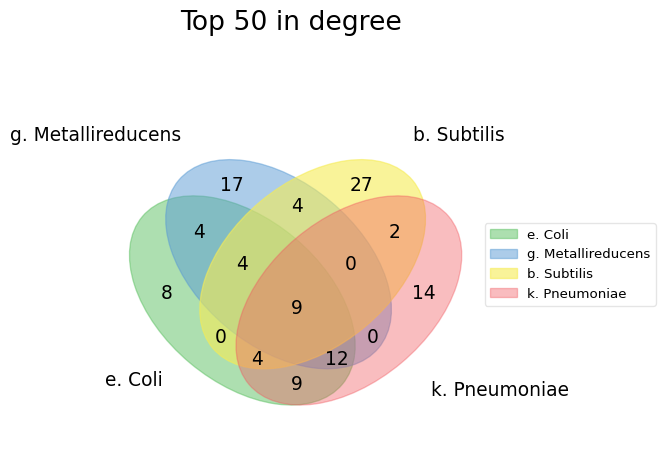

In [11]:
labels = venn.get_labels([ins['eColi'].index, ins['gMetallireducens'].index, ins['bSubtilis'].index, ins['kPneumoniae'].index], fill=['number', 'logic'])
vals = [i.split(": ",1)[1] for i in list(labels.values())]
labs = dict(zip(list(labels.keys()), vals))

fig, ax = venn.venn4(labs, names=['e. Coli', 'g. Metallireducens', 'b. Subtilis', 'k. Pneumoniae'], figsize=(5,5))
fig.suptitle('Top 50 in degree', size=20, va='bottom')
fig.show()
fig.savefig('./cascade_venn.pdf', bbox_inches='tight')

/Users/mtsui1/opt/anaconda3/envs/gen/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


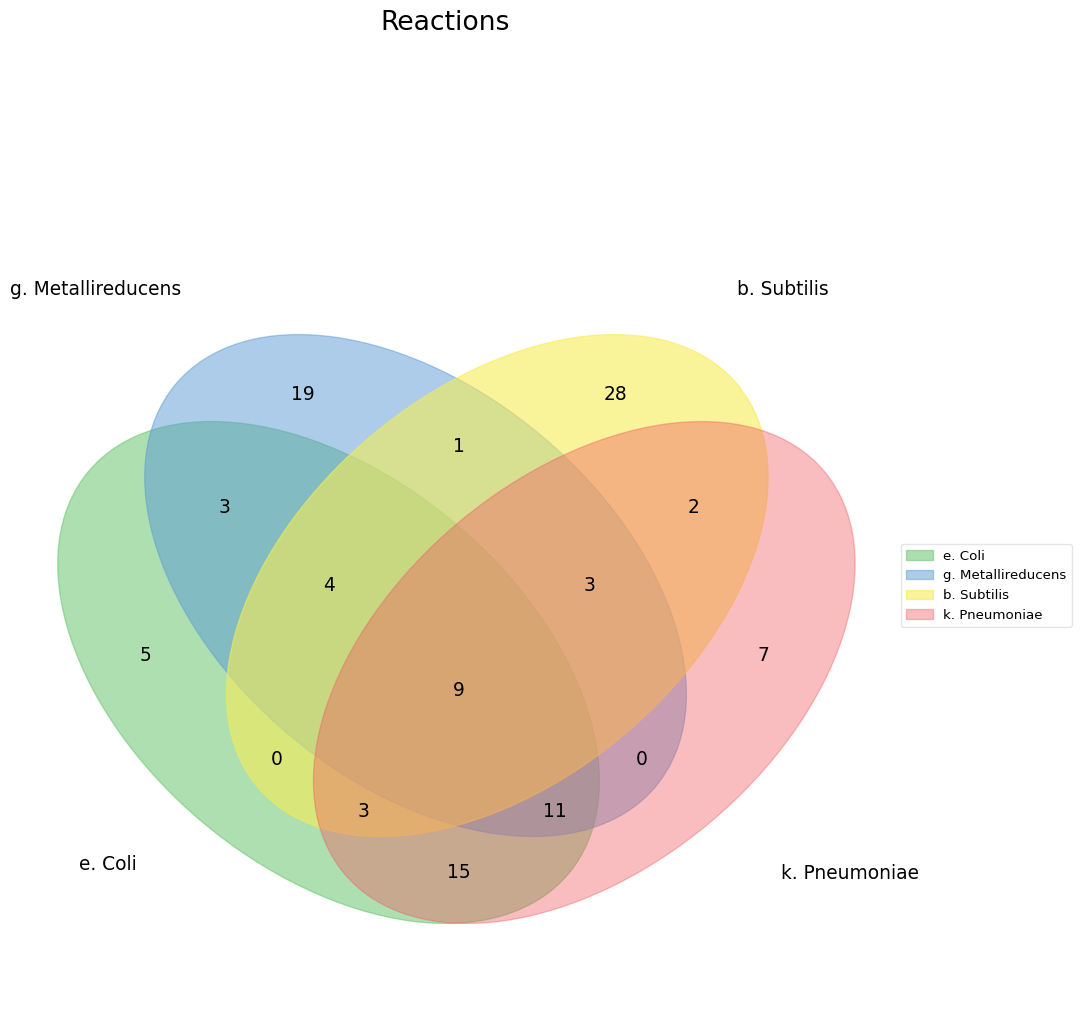

In [71]:
labels = venn.get_labels([outs['eColi'].index, outs['gMetallireducens'].index, outs['bSubtilis'].index, outs['kPneumoniae'].index], fill=['number', 'logic'])
vals = [i.split(": ",1)[1] for i in list(labels.values())]
labs = dict(zip(list(labels.keys()), vals))

fig, ax = venn.venn4(labs, names=['e. Coli', 'g. Metallireducens', 'b. Subtilis', 'k. Pneumoniae'])
fig.suptitle('Reactions', size=20, va='bottom')
fig.show()
fig.savefig('./cascade_venn.pdf', bbox_inches='tight')

In [75]:
print(common_top_in)
print(common_top_out)

Index(['AKGDH', 'SUCOAS', 'ACGS', 'PDH', 'ALATA_L', 'SERAT', 'ACS', 'ACACT1r',
       'PTAr'],
      dtype='object')
Index(['SERAT', 'SUCOAS', 'ACACT7r', 'ACACT1r', 'PTAr', 'PTA2', 'G1PACT', 'CS',
       'ALATA_L'],
      dtype='object')


In [76]:
common_top_in.intersection(common_top_out)

Index(['SUCOAS', 'ALATA_L', 'SERAT', 'ACACT1r', 'PTAr'], dtype='object')

In [56]:
for name in ['gMetallireducens', 'kPneumoniae', 'bSubtilis', 'eColi']:
    top50 = ins[name]
    print(top50.loc[common_top_in])

AKGDH      61
SUCOAS     56
ACGS       55
PDH        54
ALATA_L    52
SERAT      51
ACS        51
ACACT1r    49
PTAr       48
dtype: int64
AKGDH      63
SUCOAS     57
ACGS       54
PDH        77
ALATA_L    79
SERAT      57
ACS        55
ACACT1r    51
PTAr       51
dtype: int64
AKGDH      73
SUCOAS     68
ACGS       46
PDH        77
ALATA_L    48
SERAT      68
ACS        68
ACACT1r    66
PTAr       65
dtype: int64
AKGDH      63
SUCOAS     63
ACGS       52
PDH        81
ALATA_L    72
SERAT      57
ACS        60
ACACT1r    53
PTAr       52
dtype: int64


In [57]:
for name in ['gMetallireducens', 'kPneumoniae', 'bSubtilis', 'eColi']:
    top50 = outs[name]
    print(top50.loc[common_top_out])

SERAT      76
SUCOAS     67
ACACT7r    67
ACACT1r    66
PTAr       65
PTA2       59
G1PACT     57
CS         57
ALATA_L    47
dtype: int64
SERAT      72
SUCOAS     40
ACACT7r    36
ACACT1r    54
PTAr       55
PTA2       37
G1PACT     37
CS         38
ALATA_L    52
dtype: int64
SERAT      81
SUCOAS     49
ACACT7r    62
ACACT1r    61
PTAr       60
PTA2       49
G1PACT     61
CS         48
ALATA_L    53
dtype: int64
SERAT      62
SUCOAS     38
ACACT7r    49
ACACT1r    47
PTAr       47
PTA2       33
G1PACT     33
CS         34
ALATA_L    50
dtype: int64


### Betweenness centrality

In [15]:
betweenness_centrality = dict()
for name in ['gMetallireducens', 'kPneumoniae', 'bSubtilis', 'eColi']:
    bc = nx.betweenness_centrality(g_list[name])
    bc_sort = dict(sorted(bc.items(), key=lambda x: x[1], reverse=True))
    betweenness_centrality[name] = pd.DataFrame(list(bc_sort.items())[0:50]).set_index(0)[1]

In [16]:
betweenness_centrality

{'gMetallireducens': 0
 MCOATA       0.115503
 ACOATA       0.064704
 NDPK2        0.059557
 CTPS2        0.048024
 ALATA_L      0.047413
 SERAT        0.046863
 OOR2r        0.045921
 ACGS         0.044659
 ASPTA        0.043949
 PEPCK_re     0.042020
 POR5         0.041449
 GLNS         0.039783
 GHMT2r       0.033179
 UAGAAT       0.031803
 NADFADOR     0.031456
 APSR         0.030571
 POR          0.029477
 ACITL        0.029192
 LACD         0.028491
 GUAPRT       0.027625
 UMPK         0.026415
 GF6PTA       0.025177
 GLUPRT       0.024991
 AHCi         0.024526
 DPLPTAT      0.023757
 TRPS1        0.023591
 SULR3        0.023216
 GALUi        0.022861
 UACGAMOAT    0.022509
 CYTK1        0.021946
 UAGAATN      0.021928
 PGI          0.021409
 RNDR3        0.021375
 ADOCBLS      0.020954
 CPPPGOAN2    0.020784
 UAGPT3       0.020256
 G3PD         0.019716
 GLYTA        0.019428
 FRD2rpp      0.019210
 ICYSDS       0.019195
 AOXSr2       0.018325
 ADK3         0.017284
 NDPK1     

In [17]:
# intersection of top 50 highest betw centrality
common_top_bc = (betweenness_centrality['gMetallireducens'].index).intersection(betweenness_centrality['eColi'].index).intersection(betweenness_centrality['kPneumoniae'].index).intersection(betweenness_centrality['bSubtilis'].index)

In [18]:
common_top_bc

Index(['NDPK2', 'CTPS2', 'ALATA_L', 'SERAT', 'ACGS', 'ASPTA', 'GLNS', 'GHMT2r',
       'GF6PTA', 'GLUPRT'],
      dtype='object', name=0)

### Cascade number

In [12]:
class CascadeNumber:
    
    def __init__(self, dg):
        self.dg = dg
        self.rg = nx.reverse_view(dg)
        self.knockouts = set()
        self.cn = 0
    
    def calculate(self, n, first=True, verbose=False):
        if verbose:
            print("checking node : {}".format(n))


        # first recursion
        if first:
            self.knockouts = set()
            self.cn = 0
            
            self.knockouts.add(n)
            for n in self.dg.neighbors(n):
                self.calculate(n, first=False)
            return self.cn
        
        # every other recursion
        else:
            # stops self loops
            if n in self.knockouts:
                return
        
            parent_nodes = set(self.rg.neighbors(n))
            
            # all parent nodes have been knocked out
            if (parent_nodes.intersection(self.knockouts) == parent_nodes):
                self.cn += 1
                self.knockouts.add(n)
                for child in self.dg.neighbors(n):
                    self.calculate(child, first=False)
                    
            # not all parent nodes have been knocked out
            else:
                return
        
cascade = dict()
for name in mats.keys():
    cn = CascadeNumber(g_list[name])
    df = pd.DataFrame(
            np.array([[n, cn.calculate(n)] for n in g_list[name].nodes()]), 
            columns = ['Node', "CascadeNumber"]
        )
    df['CascadeNumber'] = df['CascadeNumber'].apply(pd.to_numeric)
    cascade[name] = df.sort_values(by="CascadeNumber", ascending=False,ignore_index=True).loc[0:49,]

In [77]:
cascade['eColi']

,Node,CascadeNumber
0,GTPCI,7
1,GLUTRS,7
2,ASAD,7
3,MECDPDH5,7
4,XAND,6
5,MPTS,6
6,GLUTRR,6
7,HSDy,6
8,HSK,5
9,G1SAT,5


In [21]:
# intersection of top 50 highest cascade number
#for name in ['gMetallireducens', 'kPneumoniae', 'bSubtilis', 'eColi']:
common_top_casc = np.intersect1d(np.intersect1d(cascade['gMetallireducens']['Node'], cascade['bSubtilis']['Node']), np.intersect1d(cascade['eColi']['Node'], cascade['kPneumoniae']['Node']))
#    common_top_bc = (betweenness_centrality['gMetallireducens'].index).intersection(betweenness_centrality['eColi'].index).intersection(betweenness_centrality['kPneumoniae'].index).intersection(betweenness_centrality['bSubtilis'].index)

In [19]:
print(common_top_in)
print(common_top_out)
print(common_top_bc)

Index(['AKGDH', 'SUCOAS', 'ACGS', 'PDH', 'ALATA_L', 'SERAT', 'ACS', 'ACACT1r',
       'PTAr'],
      dtype='object')
Index(['SERAT', 'SUCOAS', 'ACACT7r', 'ACACT1r', 'PTAr', 'PTA2', 'G1PACT', 'CS',
       'ALATA_L'],
      dtype='object')
Index(['NDPK2', 'CTPS2', 'ALATA_L', 'SERAT', 'ACGS', 'ASPTA', 'GLNS', 'GHMT2r',
       'GF6PTA', 'GLUPRT'],
      dtype='object', name=0)


/Users/mtsui1/opt/anaconda3/envs/gen/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


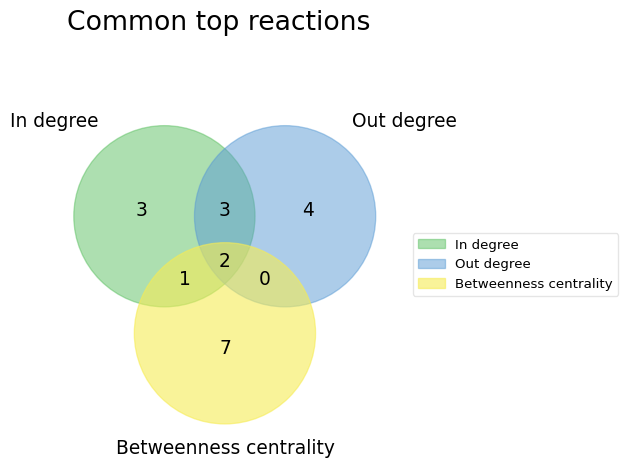

In [24]:
labels = venn.get_labels([common_top_in, common_top_out, common_top_bc], fill=['number', 'logic'])
vals = [i.split(": ",1)[1] for i in list(labels.values())]
labs = dict(zip(list(labels.keys()), vals))

fig, ax = venn.venn3(labs, names=['In degree', 'Out degree', 'Betweenness centrality'], figsize=(5,5))
fig.suptitle('Common top reactions', size=20, va='bottom')
fig.show()
fig.savefig('./cascade_venn.pdf', bbox_inches='tight')

In [84]:
clus_coeff = dict()
for name in ['gMetallireducens', 'kPneumoniae', 'bSubtilis', 'eColi']:
    cc = nx.clustering(g_list[name])
    cc_sort = dict(sorted(cc.items(), key=lambda x: x[1], reverse=True))
    clus_coeff[name] = pd.DataFrame(list(cc_sort.items())[0:50]).set_index(0)[1]

In [85]:
clus_coeff

{'gMetallireducens': 0
 ADNK1            1.000000
 ADPRDP           1.000000
 RBK              1.000000
 LPD5             1.000000
 MACPD            1.000000
 ASPTRS           1.000000
 LacR             1.000000
 FTHFCL           1.000000
 NTPP7            1.000000
 NTPP1            1.000000
 NTPP5            1.000000
 CYOO2pp          1.000000
 NO3R3pp          1.000000
 ASR2             1.000000
 HEX4             1.000000
 FRDPPCR2         0.928854
 FRNDPR2r         0.928854
 CODH4            0.928571
 NIT1b            0.925926
 I4FE4SR          0.910603
 VNDH_2           0.875000
 SSALy            0.857143
 FMNAT            0.850000
 ICDHyr           0.846003
 MMM2             0.839286
 4HBZR            0.839239
 FLNDPR2r         0.833333
 PPCCYTC1pp       0.833333
 SULR3            0.832642
 MECDPDH4         0.829876
 GLUSx            0.826509
 I2FE2SS2         0.815199
 VCOAD            0.812500
 PPPGO4           0.804314
 BUTAFDOR         0.783333
 PACCOAL          0.768254
 PACC

In [86]:
# intersection of top 50 highest betw centrality
common_top_cc = (clus_coeff['gMetallireducens'].index).intersection(clus_coeff['eColi'].index).intersection(clus_coeff['kPneumoniae'].index).intersection(clus_coeff['bSubtilis'].index)

In [87]:
common_top_cc

Index(['ICDHyr'], dtype='object', name=0)

In [6]:
(mats['sCerevisiae'].columns).intersection(mats['eColi'].columns).intersection(mats['kPneumoniae'].columns).intersection(mats['bSubtilis'].columns).intersection(mats['sCerevisiae'].columns)

Index(['HEX1', 'GALUi', 'NDPK2', 'RNDR4', 'UDPG4E', 'UMPK', 'GALS3', 'G6PDH2r',
       'PGI', 'PGMT',
       ...
       'UPP3S', 'HMPK1', 'DHQTi', 'NMNAT', 'NADS1', 'SHK3Dr', 'HMBS', 'UPPDC1',
       'PPBNGS', 'CPPPGO'],
      dtype='object', length=230)

In [7]:
mats['sCerevisiae'].columns

Index(['13BGH', '13GS', 'GLUK', 'HEX1', 'SBTR', 'GALUi', 'NDP7', 'NDPK2',
       'RNDR4', 'UDPG4E',
       ...
       'CERS124er', 'CERS126er', 'CERS224er', 'CERS226er', 'G6PDH2er',
       'SBPP1er', 'SBPP2er', 'BACCL', 'PPBNGS', 'CPPPGO'],
      dtype='object', length=881)

In [9]:
!pip install matplotlib-venn

  Created wheel for matplotlib-venn: filename=matplotlib_venn-0.11.6-py3-none-any.whl size=32062 sha256=f5e1562f651c3cc35ab0868f363c0a05cfefb8e4a3a625d674898e9768bbf3d4
  Stored in directory: /Users/mtsui1/Library/Caches/pip/wheels/83/b1/0d/2f0c1d1b8ac6eb051dac0775adc44c8a83a0bf1dafc2b2becc
Successfully built matplotlib-venn


In [33]:
%matplotlib inline

import venn


/Users/mtsui1/opt/anaconda3/envs/gen/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  This is separate from the ipykernel package so we can avoid doing imports until


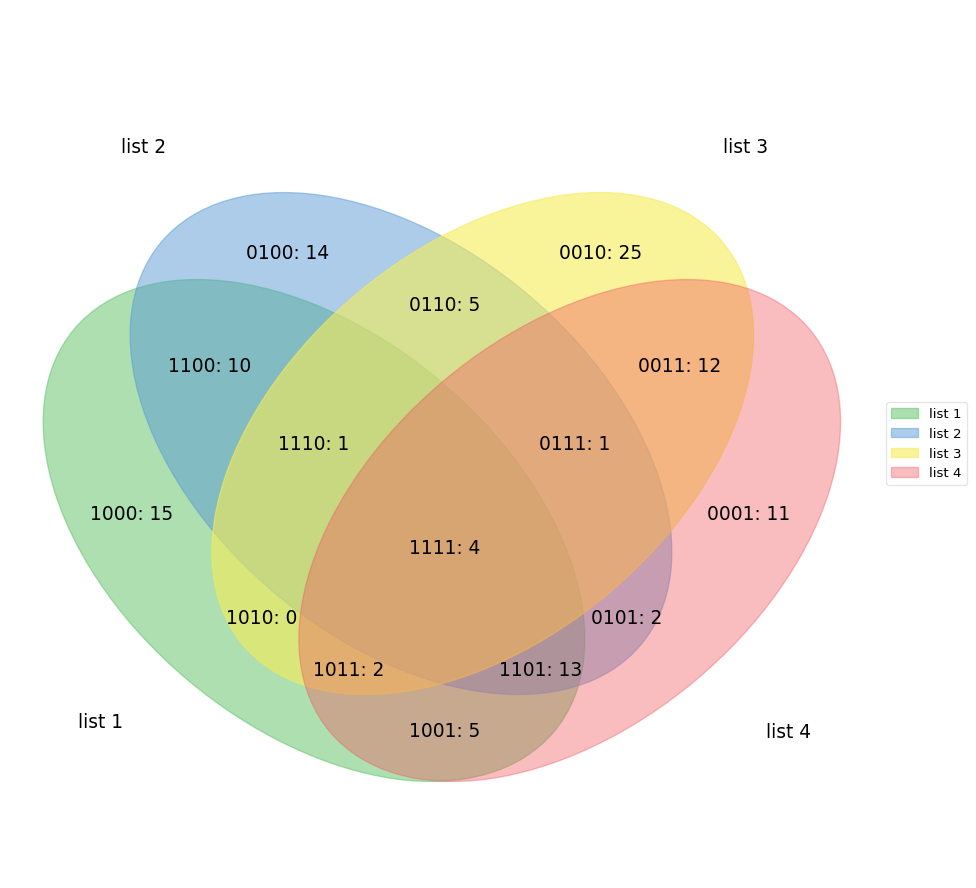

In [29]:
labels = venn.get_labels([cascade['eColi']['Node'], cascade['gMetallireducens']['Node'], cascade['bSubtilis']['Node'], cascade['kPneumoniae']['Node']], fill=['number', 'logic'])
fig, ax = venn.venn4(labels, names=['list 1', 'list 2', 'list 3', 'list 4'])
fig.show()

/Users/mtsui1/opt/anaconda3/envs/gen/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


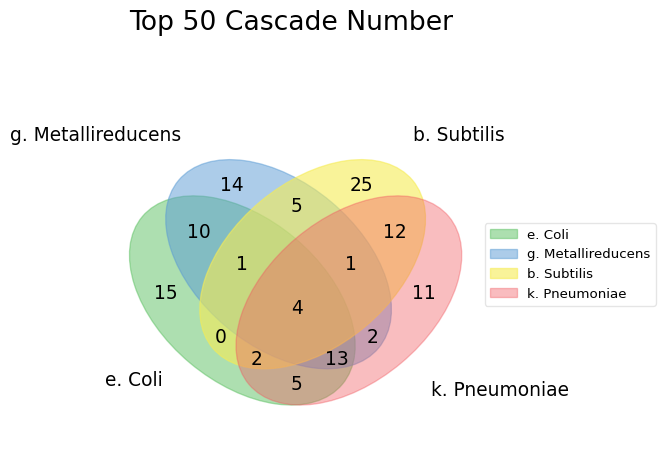

In [13]:
labels = venn.get_labels([cascade['eColi']['Node'], cascade['gMetallireducens']['Node'], cascade['bSubtilis']['Node'], cascade['kPneumoniae']['Node']], fill=['number', 'logic'])
vals = [i.split(": ",1)[1] for i in list(labels.values())]
labs = dict(zip(list(labels.keys()), vals))

fig, ax = venn.venn4(labs, names=['e. Coli', 'g. Metallireducens', 'b. Subtilis', 'k. Pneumoniae'], figsize=(5,5))
fig.suptitle('Top 50 Cascade Number', size=20, va='bottom')
fig.show()
fig.savefig('./cascade_venn.pdf', bbox_inches='tight')

In [26]:
vals = list(labels.values())
vals

['0001: 11',
 '0010: 25',
 '0011: 12',
 '0100: 14',
 '0101: 2',
 '0110: 5',
 '0111: 1',
 '1000: 15',
 '1001: 5',
 '1010: 0',
 '1011: 2',
 '1100: 10',
 '1101: 13',
 '1110: 1',
 '1111: 4']

In [28]:
[i.split(": ",1)[1] for i in vals]

['11',
 '25',
 '12',
 '14',
 '2',
 '5',
 '1',
 '15',
 '5',
 '0',
 '2',
 '10',
 '13',
 '1',
 '4']

In [42]:
dict(zip(list(labels.keys()), vals))

{'0001': '11',
 '0010': '25',
 '0011': '12',
 '0100': '14',
 '0101': '2',
 '0110': '5',
 '0111': '1',
 '1000': '15',
 '1001': '5',
 '1010': '0',
 '1011': '2',
 '1100': '10',
 '1101': '13',
 '1110': '1',
 '1111': '4'}

In [39]:
labels.keys()

dict_keys(['0001', '0010', '0011', '0100', '0101', '0110', '0111', '1000', '1001', '1010', '1011', '1100', '1101', '1110', '1111'])

In [47]:
len(np.intersect1d(cascade['kPneumoniae']['Node'], cascade['bSubtilis']['Node']))

19

/Users/mtsui1/opt/anaconda3/envs/gen/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


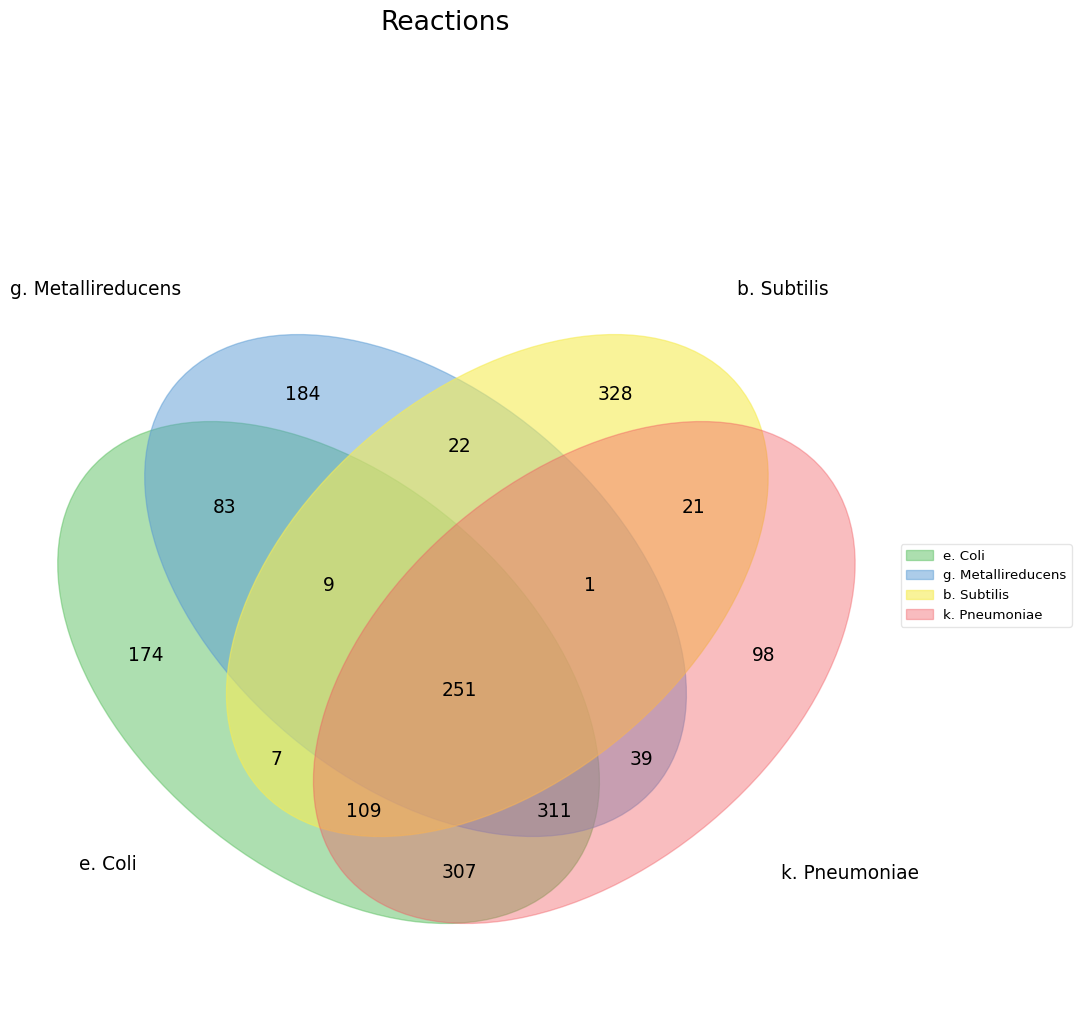

In [67]:
labels = venn.get_labels([mats['eColi'].columns, mats['gMetallireducens'].columns, mats['bSubtilis'].columns, mats['kPneumoniae'].columns], fill=['number', 'logic'])
vals = [i.split(": ",1)[1] for i in list(labels.values())]
labs = dict(zip(list(labels.keys()), vals))

fig, ax = venn.venn4(labs, names=['e. Coli', 'g. Metallireducens', 'b. Subtilis', 'k. Pneumoniae'])
fig.suptitle('Reactions', size=20, va='bottom')
fig.show()
fig.savefig('./cascade_venn.pdf', bbox_inches='tight')

/Users/mtsui1/opt/anaconda3/envs/gen/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


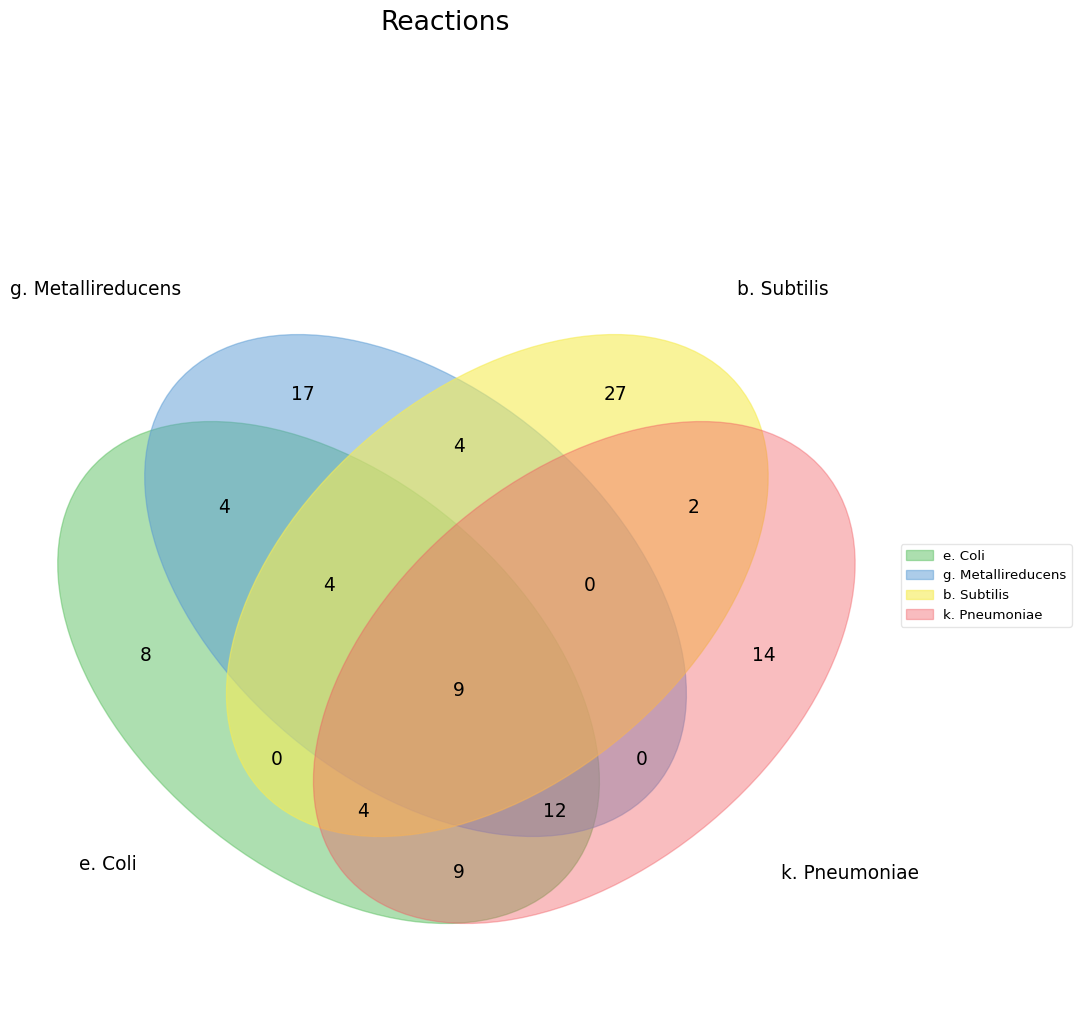